### CNN Sentiment Classifier

Reference [Jon Krohn](https://github.com/the-deep-learners/TensorFlow-LiveLessons/blob/master/notebooks/convolutional_sentiment_classifier.ipynb)

A convolutional neural net to classify IMDB movie reviews by their sentiment.



Convolutional layers work well on linear data vectors - which our word vectors are (lists of tokenized words) - we use the 1D Conv layers

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D
# max pooling to reduce the dimensionality of the outputs
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Load Data

In [2]:
# vector-space embedding:
n_dim = 64
n_unique_words = 5000
max_review_length = 400 # we can increase this as we don't lose speed in training
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # drop out some neurons at embedding layer

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

17464789/17464789 [==============================] - 0s 0us/step


Preprocess Data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

Set Hyperparameters

In [5]:
# output directory name:
output_dir = 'weights_CNN'

# training:
epochs = 8 # train on a GPU
batch_size = 128

# convolutional layer architecture:
n_conv = 256 # filters / kernels
k_conv = 3 # kernel length (filter)

# dense layer architecture:
n_dense = 256 # num of fully connected layers
dropout = 0.2 # dropout regularization

Build the CNN model


In [6]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
# adding dropout 0.2 every step
model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(Conv1D(n_conv / 2, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
# extract strongest features, reduce dimensionality - takes max of the filter
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 64)           320000    
                                                                 
 spatial_dropout1d (Spatial  (None, 400, 64)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 398, 256)          49408     
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0

We see we have fewer parameters than the previous model

Configure the model

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Train the model

* Use a GPU!

In [10]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

# without GPU ~ 95sec per epoch

Epoch 1/8
196/196 [==============================] - 34s 146ms/step - loss: 0.4835 - accuracy: 0.7457 - val_loss: 0.2905 - val_accuracy: 0.8780
Epoch 2/8
196/196 [==============================] - 16s 80ms/step - loss: 0.2463 - accuracy: 0.9006 - val_loss: 0.2717 - val_accuracy: 0.8838
Epoch 3/8
196/196 [==============================] - 11s 58ms/step - loss: 0.1695 - accuracy: 0.9370 - val_loss: 0.2813 - val_accuracy: 0.8884
Epoch 4/8
196/196 [==============================] - 8s 43ms/step - loss: 0.1136 - accuracy: 0.9610 - val_loss: 0.2940 - val_accuracy: 0.8919
Epoch 5/8
196/196 [==============================] - 6s 32ms/step - loss: 0.0705 - accuracy: 0.9777 - val_loss: 0.3327 - val_accuracy: 0.8859
Epoch 6/8
196/196 [==============================] - 6s 30ms/step - loss: 0.0419 - accuracy: 0.9881 - val_loss: 0.3819 - val_accuracy: 0.8859
Epoch 7/8
196/196 [==============================] - 6s 31ms/step - loss: 0.0259 - accuracy: 0.9934 - val_loss: 0.4228 - val_accuracy: 0.8847
Ep


We notice much better accuracy than DNN model in T6_4

Evaluate the model

In [11]:
# select the model index from the epoch checkpoints

# model 3 = "/weights.02.keras"

model.load_weights(output_dir+"/weights.02.keras") # zero-indexed

In [12]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 2s 3ms/step


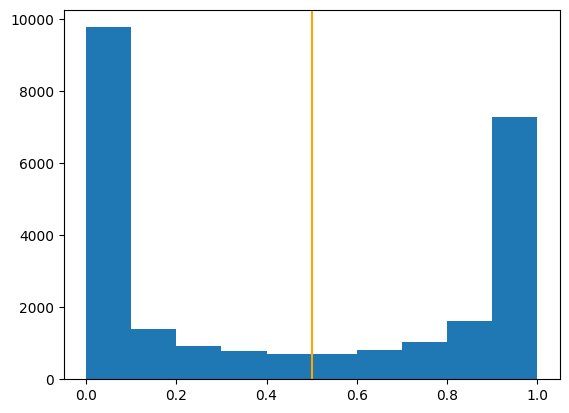

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'95.97'